In [1]:
#导入相关依赖库（不一定全部用到）
import  os
import csv
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import mindspore as ms
import mindspore.dataset as ds
import mindspore.context as context
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV

from mindspore import nn, Tensor
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy, MAE, MSE
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU')

In [2]:
hour_pd = pd.read_csv("Bike-Sharing-Dataset/hour.csv")
print("Hour")
print(hour_pd.shape[0],"rows ×", hour_pd.shape[1],"columns")
hour_pd.head()

Hour
17379 rows × 17 columns


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
day_pd = pd.read_csv("Bike-Sharing-Dataset/day.csv")
print("Day")
print(day_pd.shape[0],"rows ×", day_pd.shape[1],"columns")
day_pd.head()

Day
731 rows × 16 columns


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


1. instant: record index
2. dteday : date
3. season : season (1:winter, 2:spring, 3:summer, 4:fall)
4. yr : year (0: 2011, 1:2012)
5. mnth : month ( 1 to 12)
6. hr : hour (0 to 23)
7. holiday : weather day is holiday or not (extracted from [Web Link])
8. weekday : day of the week
9. workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
10. weathersit :
  <br> - Clear, Few clouds, Partly cloudy, Partly cloudy
  <br> - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  <br> - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  <br> - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
11. temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
12. atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
13. hum: Normalized humidity. The values are divided to 100 (max)
14. windspeed: Normalized wind speed. The values are divided to 67 (max)
15. casual: count of casual users
16. registered: count of registered users
17. cnt: count of total rental bikes including both casual and registered

In [4]:
for col in hour_pd.columns:
    if col=="instant" or col=="dteday":  
        continue
    if col=="temp" or col=="atemp" or col=="hum" or col=="windspeed":   #environment
        continue
    if col=="casual" or col=="registered":   #user
        continue
    if col=="cnt":   #bike count (label)
        continue
    print(col,":",hour_pd[col].unique())

season : [1 2 3 4]
yr : [0 1]
mnth : [ 1  2  3  4  5  6  7  8  9 10 11 12]
hr : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
holiday : [0 1]
weekday : [6 0 1 2 3 4 5]
workingday : [0 1]
weathersit : [1 2 3 4]


In [5]:
'''DAY'''
day_data = day_pd.copy()
day_dataset = day_data.dropna()  #空值数据较少，直接进行删除

day_season = day_data.pop('season')  
day_year = day_data.pop('yr')
day_month = day_data.pop('mnth')
day_holiday = day_data.pop('holiday')
day_weekday = day_data.pop('weekday')
day_workingday = day_data.pop('workingday')
day_weathersit = day_data.pop('weathersit')

instant = day_data.pop('instant')
dteday = day_data.pop('dteday')

day_data_labels = day_data.pop('cnt')
train_stats_day = day_data.describe()
train_stats_day = train_stats_day.transpose()
print("DAY")
print(train_stats_day)

DAY
            count         mean          std        min          25%  \
temp        731.0     0.495385     0.183051   0.059130     0.337083   
atemp       731.0     0.474354     0.162961   0.079070     0.337842   
hum         731.0     0.627894     0.142429   0.000000     0.520000   
windspeed   731.0     0.190486     0.077498   0.022392     0.134950   
casual      731.0   848.176471   686.622488   2.000000   315.500000   
registered  731.0  3656.172367  1560.256377  20.000000  2497.000000   

                    50%          75%          max  
temp           0.498333     0.655417     0.861667  
atemp          0.486733     0.608602     0.840896  
hum            0.626667     0.730209     0.972500  
windspeed      0.180975     0.233214     0.507463  
casual       713.000000  1096.000000  3410.000000  
registered  3662.000000  4776.500000  6946.000000  


In [6]:
'''HOUR'''
hour_data = hour_pd.copy()
hour_dataset = hour_data.dropna()  #空值数据较少，直接进行删除

hour_season = hour_data.pop('season')  
hour_year = hour_data.pop('yr')
hour_month = hour_data.pop('mnth')
hour_hour = hour_data.pop('hr')
hour_holiday = hour_data.pop('holiday')
hour_weekday = hour_data.pop('weekday')
hour_workingday = hour_data.pop('workingday')
hour_weathersit = hour_data.pop('weathersit')

instant = hour_data.pop('instant')
dteday = hour_data.pop('dteday')

hour_data_labels = hour_data.pop('cnt')
train_stats_hour = hour_data.describe()
train_stats_hour = train_stats_hour.transpose()
print("HOUR")
print(train_stats_hour)

HOUR
              count        mean         std   min      25%       50%  \
temp        17379.0    0.496987    0.192556  0.02   0.3400    0.5000   
atemp       17379.0    0.475775    0.171850  0.00   0.3333    0.4848   
hum         17379.0    0.627229    0.192930  0.00   0.4800    0.6300   
windspeed   17379.0    0.190098    0.122340  0.00   0.1045    0.1940   
casual      17379.0   35.676218   49.305030  0.00   4.0000   17.0000   
registered  17379.0  153.786869  151.357286  0.00  34.0000  115.0000   

                 75%       max  
temp          0.6600    1.0000  
atemp         0.6212    1.0000  
hum           0.7800    1.0000  
windspeed     0.2537    0.8507  
casual       48.0000  367.0000  
registered  220.0000  886.0000  


In [7]:
#对特征进行归一化
def norm(x, train_stats):
    return (x - train_stats['mean']) / train_stats['std']

In [8]:
day_normed_data = norm(day_data, train_stats_day)
print(day_data)
print(day_normed_data)

         temp     atemp       hum  windspeed  casual  registered
0    0.344167  0.363625  0.805833   0.160446     331         654
1    0.363478  0.353739  0.696087   0.248539     131         670
2    0.196364  0.189405  0.437273   0.248309     120        1229
3    0.200000  0.212122  0.590435   0.160296     108        1454
4    0.226957  0.229270  0.436957   0.186900      82        1518
..        ...       ...       ...        ...     ...         ...
726  0.254167  0.226642  0.652917   0.350133     247        1867
727  0.253333  0.255046  0.590000   0.155471     644        2451
728  0.253333  0.242400  0.752917   0.124383     159        1182
729  0.255833  0.231700  0.483333   0.350754     364        1432
730  0.215833  0.223487  0.577500   0.154846     439        2290

[731 rows x 6 columns]
         temp     atemp       hum  windspeed    casual  registered
0   -0.826097 -0.679481  1.249316  -0.387626 -0.753218   -1.924153
1   -0.720601 -0.740146  0.478785   0.749089 -1.044499   -1.91

In [9]:
hour_normed_data = norm(hour_data, train_stats_hour)
print(hour_data)
print(hour_normed_data)

       temp   atemp   hum  windspeed  casual  registered
0      0.24  0.2879  0.81     0.0000       3          13
1      0.22  0.2727  0.80     0.0000       8          32
2      0.22  0.2727  0.80     0.0000       5          27
3      0.24  0.2879  0.75     0.0000       3          10
4      0.24  0.2879  0.75     0.0000       0           1
...     ...     ...   ...        ...     ...         ...
17374  0.26  0.2576  0.60     0.1642      11         108
17375  0.26  0.2576  0.60     0.1642       8          81
17376  0.26  0.2576  0.60     0.1642       7          83
17377  0.26  0.2727  0.56     0.1343      13          48
17378  0.26  0.2727  0.65     0.1343      12          37

[17379 rows x 6 columns]
           temp     atemp       hum  windspeed    casual  registered
0     -1.334609 -1.093249  0.947345  -1.553844 -0.662736   -0.930162
1     -1.438475 -1.181698  0.895513  -1.553844 -0.561326   -0.804632
2     -1.438475 -1.181698  0.895513  -1.553844 -0.622172   -0.837666
3     -1.33460

In [10]:
'''for i in range(len(day_normed_data)):
    day_normed_data.loc[i,'winter'] = (day_season[i] == 1)*1.0
    day_normed_data.loc[i,'spring'] = (day_season[i] == 2)*1.0
    day_normed_data.loc[i,'summer'] = (day_season[i] == 3)*1.0
    day_normed_data.loc[i,'autumn'] = (day_season[i] == 4)*1.0
    day_normed_data.loc[i,'2011'] = (day_year[i] == 1)*1.0
    day_normed_data.loc[i,'2012'] = (day_year[i] == 2)*1.0
    day_normed_data.loc[i,'Jan'] = (day_month[i] == 1)*1.0
    day_normed_data.loc[i,'Feb'] = (day_month[i] == 2)*1.0
    day_normed_data.loc[i,'Mar'] = (day_month[i] == 3)*1.0
    day_normed_data.loc[i,'Apr'] = (day_month[i] == 4)*1.0
    day_normed_data.loc[i,'May'] = (day_month[i] == 5)*1.0
    day_normed_data.loc[i,'Jun'] = (day_month[i] == 6)*1.0
    day_normed_data.loc[i,'Jul'] = (day_month[i] == 7)*1.0
    day_normed_data.loc[i,'Aug'] = (day_month[i] == 8)*1.0
    day_normed_data.loc[i,'Sep'] = (day_month[i] == 9)*1.0
    day_normed_data.loc[i,'Oct'] = (day_month[i] == 10)*1.0
    day_normed_data.loc[i,'Nov'] = (day_month[i] == 11)*1.0
    day_normed_data.loc[i,'Dec'] = (day_month[i] == 12)*1.0
    day_normed_data.loc[i,'Sun'] = (day_weekday[i] == 0)*1.0
    day_normed_data.loc[i,'Mon'] = (day_weekday[i] == 1)*1.0
    day_normed_data.loc[i,'Tue'] = (day_weekday[i] == 2)*1.0
    day_normed_data.loc[i,'Wed'] = (day_weekday[i] == 3)*1.0
    day_normed_data.loc[i,'Thu'] = (day_weekday[i] == 4)*1.0
    day_normed_data.loc[i,'Fri'] = (day_weekday[i] == 5)*1.0
    day_normed_data.loc[i,'Sat'] = (day_weekday[i] == 6)*1.0
    day_normed_data.loc[i,'Clear'] = (day_weathersit[i] == 1)*1.0
    day_normed_data.loc[i,'Mist'] = (day_weathersit[i] == 2)*1.0
    day_normed_data.loc[i,'Light Rain'] = (day_weathersit[i] == 3)*1.0
    day_normed_data.loc[i,'Heavy Rain'] = (day_weathersit[i] == 4)*1.0
day_normed_data['holiday'] = day_holiday
day_normed_data['workingday'] = day_workingday
day_normed_data'''

"for i in range(len(day_normed_data)):\n    day_normed_data.loc[i,'winter'] = (day_season[i] == 1)*1.0\n    day_normed_data.loc[i,'spring'] = (day_season[i] == 2)*1.0\n    day_normed_data.loc[i,'summer'] = (day_season[i] == 3)*1.0\n    day_normed_data.loc[i,'autumn'] = (day_season[i] == 4)*1.0\n    day_normed_data.loc[i,'2011'] = (day_year[i] == 1)*1.0\n    day_normed_data.loc[i,'2012'] = (day_year[i] == 2)*1.0\n    day_normed_data.loc[i,'Jan'] = (day_month[i] == 1)*1.0\n    day_normed_data.loc[i,'Feb'] = (day_month[i] == 2)*1.0\n    day_normed_data.loc[i,'Mar'] = (day_month[i] == 3)*1.0\n    day_normed_data.loc[i,'Apr'] = (day_month[i] == 4)*1.0\n    day_normed_data.loc[i,'May'] = (day_month[i] == 5)*1.0\n    day_normed_data.loc[i,'Jun'] = (day_month[i] == 6)*1.0\n    day_normed_data.loc[i,'Jul'] = (day_month[i] == 7)*1.0\n    day_normed_data.loc[i,'Aug'] = (day_month[i] == 8)*1.0\n    day_normed_data.loc[i,'Sep'] = (day_month[i] == 9)*1.0\n    day_normed_data.loc[i,'Oct'] = (day_mont

In [11]:
day_normed_data['season'] = day_season
day_normed_data['yr'] = day_year
day_normed_data['mnth'] = day_month
day_normed_data['holiday'] = day_holiday
day_normed_data['weekday'] = day_weekday
day_normed_data['workingday'] = day_workingday
day_normed_data['weathersit'] = day_weathersit
day_normed_data

,temp,atemp,hum,windspeed,casual,registered,season,yr,mnth,holiday,weekday,workingday,weathersit
0,-0.826097,-0.679481,1.249316,-0.387626,-0.753218,-1.924153,1,0,1,0,6,0,2
1,-0.720601,-0.740146,0.478785,0.749089,-1.044499,-1.913899,1,0,1,0,0,0,2
2,-1.633538,-1.748570,-1.338358,0.746121,-1.060519,-1.555624,1,0,1,0,1,1,1
3,-1.613675,-1.609168,-0.263001,-0.389562,-1.077996,-1.411417,1,0,1,0,2,1,1
4,-1.466410,-1.503941,-1.340576,-0.046275,-1.115863,-1.370398,1,0,1,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.317763,-1.520067,0.175687,2.060015,-0.875556,-1.146717,1,1,12,0,4,1,2
727,-1.322319,-1.345768,-0.266056,-0.451822,-0.297364,-0.772419,1,1,12,0,5,1,2
728,-1.322319,-1.423370,0.877791,-0.852968,-1.003720,-1.585747,1,1,12,0,6,0,2
729,-1.308661,-1.489029,-1.014969,2.068028,-0.705157,-1.425517,1,1,12,0,0,0,1


In [12]:
day_normed_data['cnt'] = day_data_labels
day_normed_data

,temp,atemp,hum,windspeed,casual,registered,season,yr,mnth,holiday,weekday,workingday,weathersit,cnt
0,-0.826097,-0.679481,1.249316,-0.387626,-0.753218,-1.924153,1,0,1,0,6,0,2,985
1,-0.720601,-0.740146,0.478785,0.749089,-1.044499,-1.913899,1,0,1,0,0,0,2,801
2,-1.633538,-1.748570,-1.338358,0.746121,-1.060519,-1.555624,1,0,1,0,1,1,1,1349
3,-1.613675,-1.609168,-0.263001,-0.389562,-1.077996,-1.411417,1,0,1,0,2,1,1,1562
4,-1.466410,-1.503941,-1.340576,-0.046275,-1.115863,-1.370398,1,0,1,0,3,1,1,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.317763,-1.520067,0.175687,2.060015,-0.875556,-1.146717,1,1,12,0,4,1,2,2114
727,-1.322319,-1.345768,-0.266056,-0.451822,-0.297364,-0.772419,1,1,12,0,5,1,2,3095
728,-1.322319,-1.423370,0.877791,-0.852968,-1.003720,-1.585747,1,1,12,0,6,0,2,1341
729,-1.308661,-1.489029,-1.014969,2.068028,-0.705157,-1.425517,1,1,12,0,0,0,1,1796


In [13]:
#将数据集按照4：1划分成训练集和测试集
train_dataset = day_normed_data.sample(frac=0.8, random_state=0)
test_dataset = day_normed_data.drop(train_dataset.index)

#模型训练需要区分特征值与目标值，也就是我们常说的X值与Y值，此处MPG为Y值，其余的特征为X值。
train_labels = train_dataset.pop('cnt')
test_labels = test_dataset.pop('cnt')
X_train, Y_train = np.array(train_dataset), np.array(train_labels)
X_test, Y_test = np.array(test_dataset), np.array(test_labels)

#查看数据集尺寸
print('Train X：',X_train.shape)
print('Train Y：',Y_train.shape)
print('Test X：',X_test.shape)
print('Test Y：',Y_test.shape)

Train X： (585, 13)
Train Y： (585,)
Test X： (146, 13)
Test Y： (146,)


In [14]:
#将数据集转换为Tensor格式
ds_xtrain = Tensor(X_train, ms.float32)
ds_ytrain = Tensor(Y_train, ms.int32)
ds_xtest = Tensor(X_test, ms.float32)
ds_ytest = Tensor(Y_test, ms.int32)
print(ds_xtrain.shape,ds_ytrain.shape)
print(ds_xtest.shape,ds_ytest.shape)

(585, 13) (585,)
(146, 13) (146,)


In [15]:
# 定义网络
class Regression_bike(nn.Cell):
    def __init__(self):
        super(Regression_bike, self).__init__()
        self.fc1 = nn.Dense(13, 64, activation='relu')
        self.fc2 = nn.Dense(64, 64, activation='relu')
        self.fc3 = nn.Dense(64, 1, activation='relu')
        self.flatten = nn.Flatten()
        
    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
def variance(x):
    mean_x = sum(x) / len(x)
    tmp = 0.0
    for i in range(len(x)):
        tmp += pow(x[i]-mean_x,2)
    variance = tmp/len(x)

In [24]:
#定义网络，损失函数，评估指标，优化器
network = Regression_bike()
net_loss = nn.MSELoss()
net_opt = nn.RMSProp(network.trainable_params(), 0.001)
max_epoch = 1001
n=100

#使用单步训练的方式来使结果中打印出MAE、MSE
with_loss = nn.WithLossCell(network,net_loss) 
train_step = nn.TrainOneStepCell(with_loss, net_opt).set_train()
evalcell = nn.WithEvalCell(network,net_loss)
mae = nn.MAE()
mse = nn.MSE()
val_mae = nn.MAE()
val_mse = nn.MSE()

#创建一个空的Dataframe，存放训练过程数据
#column包括epoch、loss等数据
result =pd.DataFrame(columns=('_epoch','_loss','_mae','_mse','val_loss','val_mae','val_mse'))
print("Starting Training".center(115,"="))

for epoch in range(max_epoch):
    # 训练函数
    loss,val_loss = train_step(ds_xtrain,ds_ytrain),train_step(ds_xtest, ds_ytest)
    _, outputs, label = evalcell(ds_xtrain,ds_ytrain)
    _, val_outputs, val_label = evalcell(ds_xtest,ds_ytest)
    
    #每次循环都更新MAE、MSE等的值。
    mae.clear()
    mae.update(outputs, label)
    mse.clear()
    mse.update(outputs, label)
    var = variance(label)
    val_mae.clear()
    val_mae.update(val_outputs, val_label)
    val_mse.clear()
    val_mse.update(val_outputs, val_label)
    val_var = variance(val_label)
    Mae = mae.eval()
    Mse = mse.eval()
    Val_Mae = val_mae.eval()
    Val_Mse = val_mse.eval()
    nd_loss = loss.asnumpy()
    fl_loss = float(nd_loss)/24.0
    val_nd_loss = val_loss.asnumpy()
    val_fl_loss = float(val_nd_loss)/24.0
    r2 = 1 - Mse/var
    val_r2 = 1 - Val_Mse/val_var

    # 将计算结果逐行插入result
    # ignore_index=True，否则会报错，ValueError: If using all scalar values, you must pass an index
    result = result.append(pd.DataFrame({'_epoch':[epoch],'r2':r2,'_loss':fl_loss,'_mae':Mae,'_mse':Mse,'val_r2':val_r2,'val_loss':val_fl_loss,
                                       'val_mae':Val_Mae,'val_mse':Val_Mse}),ignore_index=True)

    # 每隔n个epoch展示
    if epoch%n==0:
        print('epoch:{:.0f}, loss:{:.2f}, mae:{:.2f}, mse:{:.2f}, sval_loss:{:.2f}, val_mae:{:.2f}, val_mse:{:.2f}'
              .format(epoch, fl_loss, Mae, Mse, val_fl_loss, Val_Mae, Val_Mse))
        
# 训练结果
print('\n',result)

=================================================Starting Training=================================================
epoch:0, loss:1009945.50, mae:4517.76, mse:24242293.08, val_loss:967209.00, val_mae:4450.52, val_mse:23212770.17
epoch:100, loss:841343.17, mae:4033.74, mse:19972810.94, val_loss:799657.17, val_mae:3964.43, val_mse:18984745.17
epoch:200, loss:312298.00, mae:2187.20, mse:6936841.63, val_loss:285930.92, val_mae:1987.82, val_mse:6100686.27
epoch:300, loss:210326.08, mae:1764.59, mse:4627019.86, val_loss:195434.85, val_mae:1668.18, val_mse:3852797.17
epoch:400, loss:188481.33, mae:1720.59, mse:4451005.88, val_loss:171952.69, val_mae:1610.14, val_mse:3612056.44
epoch:500, loss:176376.56, mae:1707.58, mse:4447444.71, val_loss:158661.17, val_mae:1597.82, val_mse:3598111.89
epoch:600, loss:173647.20, mae:1691.33, mse:4390179.77, val_loss:155615.94, val_mae:1594.50, val_mse:3597120.26
epoch:700, loss:171984.95, mae:1676.34, mse:4320508.04, val_loss:153888.82, val_mae:1587.14, val_

In [22]:
np.savetxt("result.txt",result,fmt="%s")

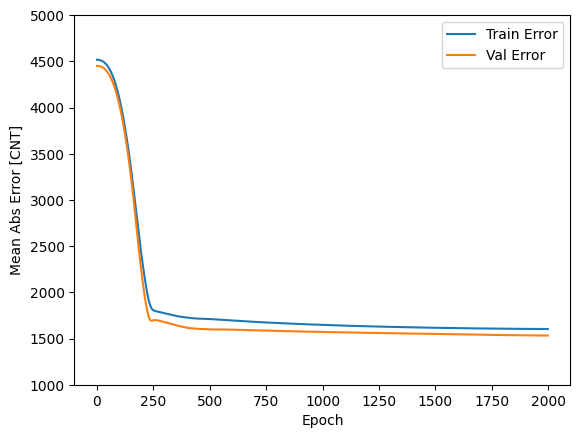

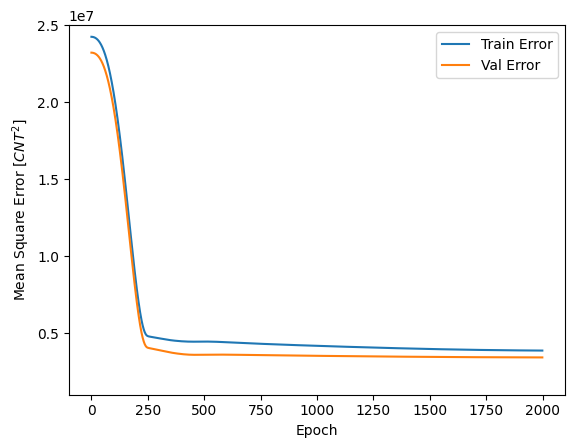

In [23]:
#绘制模型损失函数图（横轴为epoch）
def plot_history(result):
    # 此处为代码
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [CNT]')
    plt.plot(result['_epoch'], result['_mae'], label='Train Error')
    plt.plot(result['_epoch'], result['val_mae'], label='Val Error')
    plt.ylim([1000,5000])
    plt.legend()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$CNT^2$]')
    plt.plot(result['_epoch'], result['_mse'], label='Train Error')
    plt.plot(result['_epoch'], result['val_mse'], label='Val Error')
    plt.ylim([1000000,pow(5000,2)])
    plt.legend()
    plt.show()

plot_history(result)